In [91]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
import json

onlyfiles = [
    f for f in listdir("./mixed-data") if isfile(join("./mixed-data", f))
]


print(len(onlyfiles))
onlyfiles[:5]

123


['csv-2023-12-18-09-35-00-none-1035-iPhone14-0-31.36-61.49-null-NMSnore-NAvgSnore-30.94.csv',
 'csv-2023-12-18-07-42-00-none-1035-iPhone14-0-35.54-43.82-null-NMSnore-NAvgSnore-35.44.csv',
 'csv-2023-12-18-09-09-00-none-1035-iPhone14-0-30.23-39.13-null-NMSnore-NAvgSnore-30.14.csv',
 'csv-2023-12-18-07-59-00-snore-1035-iPhone14-6-33.66-63.51-07-58-20.150-58.83-47.85-32.20.csv',
 'csv-2023-12-18-09-26-00-snore-1035-iPhone14-1-33.28-42.15-09-25-00.610-42.14-42.14-33.11.csv']

In [92]:
def parse_file_name(file_name):
    pattern = r"csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+|null)-(NMSnore|\d+\.\d+)-(NAvgSnore|\d+\.\d+)-(\d+\.\d+|\-inf).csv"
    match = re.match(pattern, file_name)
    if match:
        return {
            "date": match.group(1),
            "time": match.group(2),
            "event_type": match.group(3),
            "version": int(match.group(4)),
            "snore_count": int(match.group(5)),
            "avg_db": float(match.group(6)),
            "max_db": float(match.group(7)),
            "start_snore_event_timestamp": match.group(8),
            "max_snore_db": match.group(9),
            "avg_snore_db": match.group(10),
            "noise_level": match.group(11),
        }
    else:
        print(file_name)
        raise Exception("Not possible")


parsed_data = [
    parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None
]

df = pd.DataFrame(parsed_data)
df["datetime"] = df.apply(
    lambda row: datetime.strptime(f"{row['date']} {row['time']}", "%Y-%m-%d %H-%M-%S"),
    axis=1,
)
df = df.drop(["date", "time"], axis=1)

df = df.sort_values(by="datetime")

df_hour = df.copy()

df_hour["hour"] = df["datetime"].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=["index"])
df.describe()

,version,snore_count,avg_db,max_db,datetime
count,123.0,123.000000,123.000000,123.000000,123
mean,1035.0,3.463415,34.423659,51.850244,2023-12-18 08:35:00
min,1035.0,0.000000,29.800000,33.660000,2023-12-18 07:34:00
25%,1035.0,0.000000,33.165000,43.790000,2023-12-18 08:04:30
50%,1035.0,1.000000,34.410000,52.170000,2023-12-18 08:35:00
75%,1035.0,7.000000,35.805000,60.080000,2023-12-18 09:05:30
max,1035.0,15.000000,40.400000,71.500000,2023-12-18 09:36:00
std,0.0,4.490961,2.003583,8.990750,NaN


In [93]:
df = df[df["event_type"] == "snore"]
df["max_snore_db"] = df["max_snore_db"].astype(float)
df["avg_snore_db"] = df["avg_snore_db"].astype(float)
df["noise_level"] = df["noise_level"].astype(float)
df.dtypes

event_type                             object
version                                 int64
snore_count                             int64
avg_db                                float64
max_db                                float64
start_snore_event_timestamp            object
max_snore_db                          float64
avg_snore_db                          float64
noise_level                           float64
datetime                       datetime64[ns]
dtype: object

In [94]:
def apply_increase_level(noise_level, avg_snore_db):
    percentage_increase = ((avg_snore_db - noise_level) / noise_level) * 100
    return percentage_increase


df["noise_increase_percentage"] = df.apply(
    lambda row: apply_increase_level(row["noise_level"], row["avg_snore_db"]), axis=1
)

df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,max_snore_db,avg_snore_db,noise_level,datetime,noise_increase_percentage
10,snore,1035,3,36.94,49.72,07-43-38.652,46.97,45.26,36.56,2023-12-18 07:44:00,23.796499
11,snore,1035,1,36.32,46.37,07-44-04.027,41.73,41.73,36.12,2023-12-18 07:45:00,15.531561
13,snore,1035,3,35.80,42.85,07-46-10.778,41.76,40.50,35.50,2023-12-18 07:47:00,14.084507
14,snore,1035,6,37.24,50.86,07-47-06.278,50.86,45.70,36.58,2023-12-18 07:48:00,24.931657
15,snore,1035,4,37.06,55.49,07-48-35.025,50.91,45.32,36.18,2023-12-18 07:49:00,25.262576
16,snore,1035,14,37.39,60.86,07-49-04.273,55.49,45.20,35.54,2023-12-18 07:50:00,27.180642
17,snore,1035,11,35.99,49.76,07-50-14.023,49.76,43.40,34.50,2023-12-18 07:51:00,25.797101
18,snore,1035,11,36.69,49.64,07-51-18.893,49.01,43.96,34.86,2023-12-18 07:52:00,26.104418
19,snore,1035,12,36.72,60.13,07-52-04.523,48.16,43.23,34.53,2023-12-18 07:53:00,25.195482
20,snore,1035,13,37.18,64.52,07-53-00.265,58.79,47.15,34.62,2023-12-18 07:54:00,36.192952


In [95]:
df["datetime"] = pd.to_datetime(df["datetime"])

thresholds = {"Quiet": 10, "Light": 20, "Loud": 30, "Severe": 100}


def categorize_noise_level(row):
    for category, threshold in thresholds.items():
        if row["noise_increase_percentage"] < threshold:
            return category
    return "Quiet"


df["category"] = df.apply(categorize_noise_level, axis=1)

grouped = df.groupby([pd.Grouper(key="datetime", freq="15T"), "category"])

grouped_daily = df.groupby([pd.Grouper(key="datetime", freq="D"), "category"])

# grouped.head()
counts = grouped.size().reset_index(name="counts")
counts_daily = grouped_daily.size().reset_index(name="counts")

# counts
pivot_table = counts.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table_daily = counts_daily.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table

category,Light,Loud,Quiet,Severe
datetime,,,,
2023-12-18 07:30:00,0.0,1.0,0.0,0.0
2023-12-18 07:45:00,2.0,6.0,0.0,6.0
2023-12-18 08:00:00,0.0,1.0,0.0,8.0
2023-12-18 08:15:00,0.0,1.0,1.0,8.0
2023-12-18 08:30:00,1.0,0.0,0.0,9.0
2023-12-18 08:45:00,1.0,0.0,1.0,1.0
2023-12-18 09:00:00,1.0,1.0,0.0,2.0
2023-12-18 09:15:00,2.0,2.0,1.0,6.0
2023-12-18 09:30:00,1.0,2.0,0.0,2.0


In [96]:

pivot_table_daily

category,Light,Loud,Quiet,Severe
datetime,,,,
2023-12-18,8,14,3,42


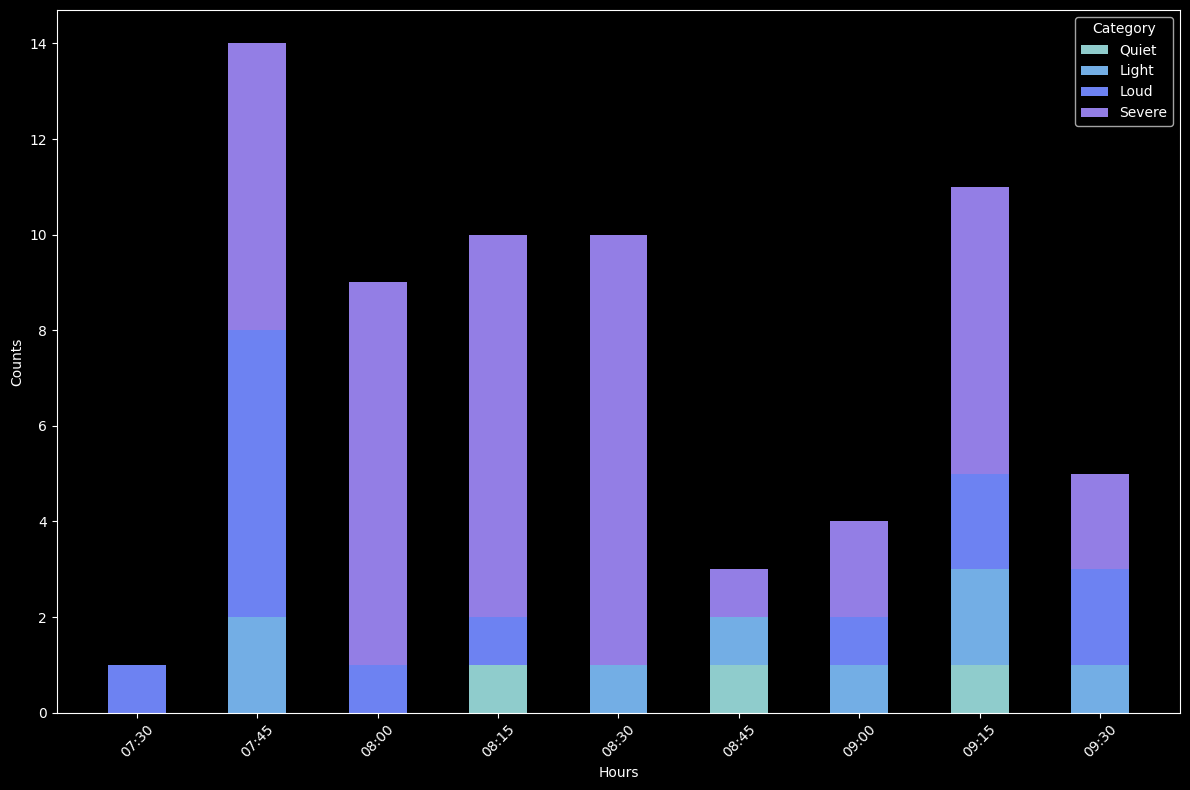

In [97]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table.index,
        pivot_table.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.005,
    )
    if bottom is None:
        bottom = pivot_table.get(category, 0)
    else:
        bottom += pivot_table.get(category, 0)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

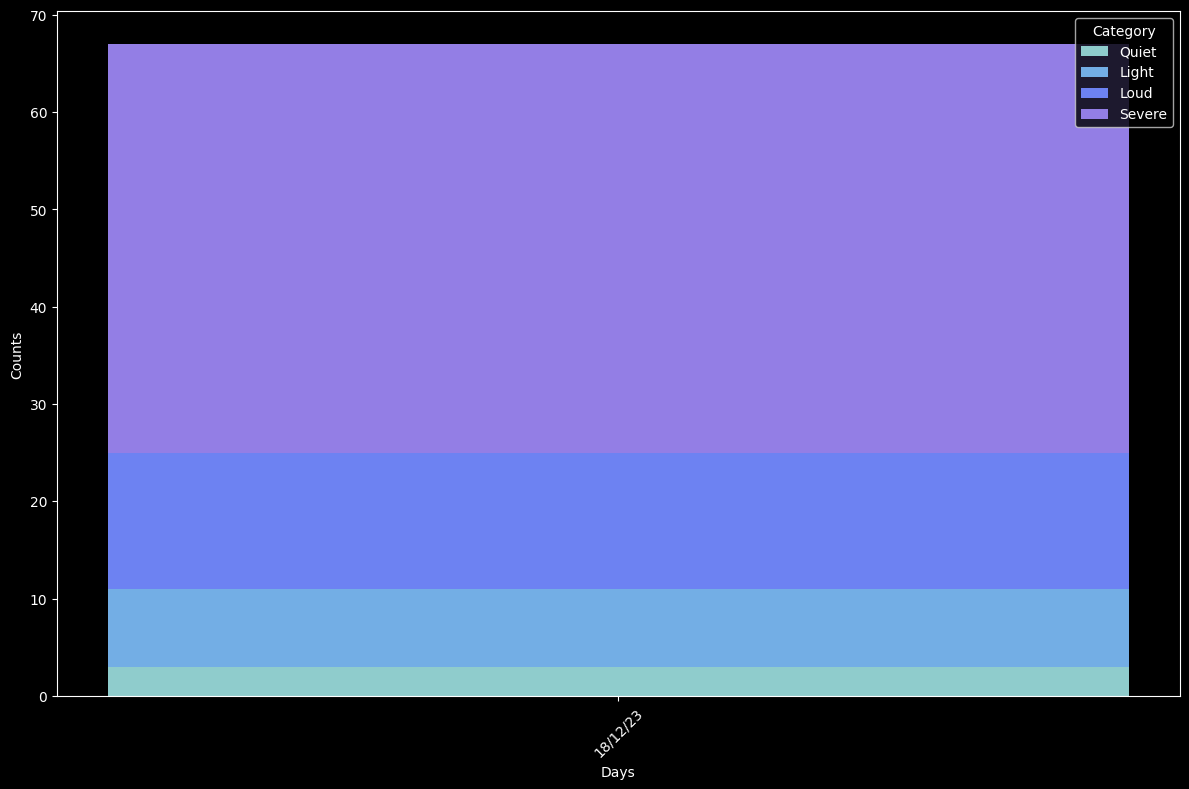

In [98]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table_daily.index,
        pivot_table_daily.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.5,
    )
    if bottom is None:
        bottom = pivot_table_daily.get(category, 0)
    else:
        bottom += pivot_table_daily.get(category, 0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
plt.xticks(pivot_table_daily.index)

plt.xlabel("Days")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

In [99]:
pivot_table_reset_index = pivot_table.reset_index()


api_json_object = json.loads(
    pivot_table_reset_index.to_json(orient="records", date_format="iso")
)


# with open("dump_graph.json", 'w') as f:
#     json.dump(api_json_object, f, indent=4)

# f.close()

api_json_object[:5]

[{'datetime': '2023-12-18T07:30:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 1.0,
  'Severe': 0.0},
 {'datetime': '2023-12-18T07:45:00.000',
  'Light': 2.0,
  'Loud': 6.0,
  'Quiet': 14.0,
  'Severe': 6.0},
 {'datetime': '2023-12-18T08:00:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 9.0,
  'Severe': 8.0},
 {'datetime': '2023-12-18T08:15:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 10.0,
  'Severe': 8.0},
 {'datetime': '2023-12-18T08:30:00.000',
  'Light': 1.0,
  'Loud': 0.0,
  'Quiet': 10.0,
  'Severe': 9.0}]